# S&P 500 – Processed Dataset Validation & Analysis

This notebook represents the final validation stage of the data pipeline.

Objectives:

1. Load and inspect the processed dataset  
2. Validate dataset structure and integrity  
3. Explain rolling-feature NaN behavior  
4. Confirm chronological correctness  
5. Analyze price dynamics  
6. Evaluate return properties and distribution  
7. Study moving averages as trend indicators  
8. Examine rolling volatility as a risk measure  
9. Measure cumulative performance  
10. Quantify downside risk using Maximum Drawdown  
11. Compute annualized volatility  
12. Evaluate risk-adjusted performance using the Sharpe Ratio  
13. Analyze time-varying performance with Rolling Sharpe Ratio  
14. Examine relationships between engineered features (Correlation Matrix)  
15. Conduct statistical testing (ADF stationarity test and Jarque-Bera normality test)

The dataset at this stage is fully cleaned and feature-engineered.

## 1. Load Processed Dataset

We load the cleaned dataset and ensure correct datetime formatting.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../data/processed/sp500_clean.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

df['Return'] = df['Price'].pct_change()

df.head()

,Date,Price,Open,High,Low,Change %,Year,Month,Day,Return,MA_20,MA_50,Volatility_20
0,1990-01-02,359.7,353.4,359.7,352.0,1.78,1990,1,2,NaN,NaN,NaN,NaN
1,1990-01-03,358.8,359.7,360.6,357.9,-0.25,1990,1,3,-0.002502,NaN,NaN,NaN
2,1990-01-04,355.7,358.8,358.8,352.9,-0.86,1990,1,4,-0.008640,NaN,NaN,NaN
3,1990-01-05,352.2,355.7,355.7,351.4,-0.98,1990,1,5,-0.009840,NaN,NaN,NaN
4,1990-01-08,353.8,352.2,354.2,350.5,0.45,1990,1,8,0.004543,NaN,NaN,NaN


## 2. Dataset Structure & Integrity

We validate:

- Data types
- Summary statistics
- Missing values
- Duplicate rows

This ensures the preprocessing pipeline executed correctly.

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df.isna().sum()

In [ ]:
df.duplicated().sum()

## 3. Rolling Features and NaN Behavior

The dataset contains NaN values in:

- MA_20
- MA_50
- Volatility_20

These are mathematically expected.

### Moving Averages

A rolling window of size N requires N observations.

- MA_20 → first valid value at index 19
- MA_50 → first valid value at index 49

Thus:
- MA_20 has 19 NaNs
- MA_50 has 49 NaNs

### Volatility

Volatility is calculated as a rolling standard deviation of returns.

Because:
- The first return is NaN (no prior price),
- And 20 valid returns are required,

The first valid volatility appears at index 20.

Therefore:
- Volatility_20 has 20 NaNs

These values confirm correct rolling implementation.
They are not data errors.

In [ ]:
df.head(25)

The early rows confirm:

- Return is NaN only at the first observation
- MA_20 appears at index 19
- Volatility_20 appears at index 20
- MA_50 appears at index 49

Rolling logic is implemented correctly.

In [ ]:
df.tail()

Final rows contain no NaNs in rolling features.

This confirms:

- No unintended truncation
- Full time coverage
- Stable feature computation across the dataset

## 4. Chronological Order

Time-series calculations require strictly ordered observations.

Incorrect sorting would distort:

- Returns
- Moving averages
- Volatility

We verify ordering below.

In [ ]:
df[['Date']].head()

In [ ]:
df[['Date']].tail()

## 5. Price Dynamics

The S&P 500 price series exhibits:

- Long-term upward drift
- Cyclical corrections
- Periods of structural volatility

Prices are non-stationary.
Therefore, financial modeling relies primarily on returns.

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

df = df.sort_values('Date').reset_index(drop=True)

plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Price'])
plt.title("S&P 500 Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.hist(df['Price'], bins=50)
plt.title("Price Distribution")
plt.tight_layout()
plt.show()

print("Price Summary Statistics")
print("-------------------------")
print("Mean:", round(df['Price'].mean(),2))
print("Std Dev:", round(df['Price'].std(),2))
print("Max:", round(df['Price'].max(),2))
print("Min:", round(df['Price'].min(),2))
print("Skewness:", round(df['Price'].skew(),2))
print("Kurtosis:", round(df['Price'].kurt(),2))

## 6. Return Properties

Returns are computed as:

Return_t = (Price_t / Price_{t-1}) - 1

Properties:

- Centered near zero
- More stationary than prices
- Capture daily market fluctuations

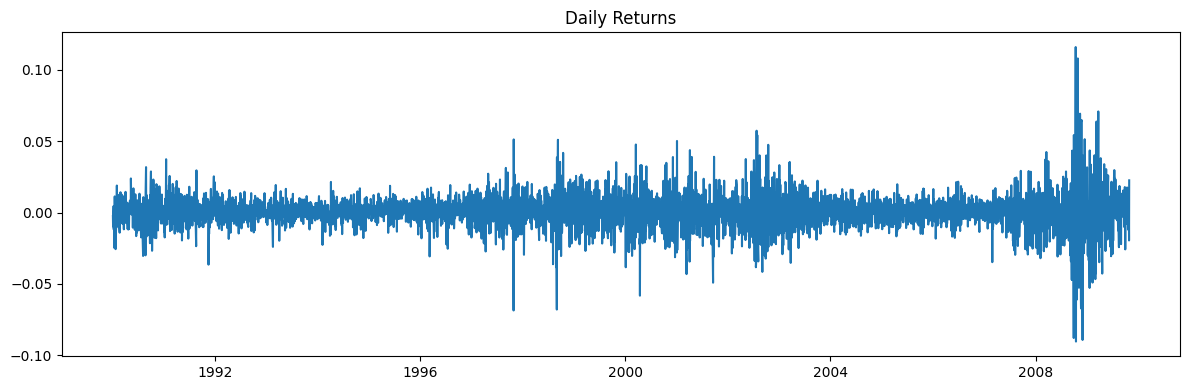

In [109]:
plt.figure(figsize=(12,4))
plt.plot(df['Date'], df['Return'])
plt.title("Daily Returns")
plt.tight_layout()
plt.show()

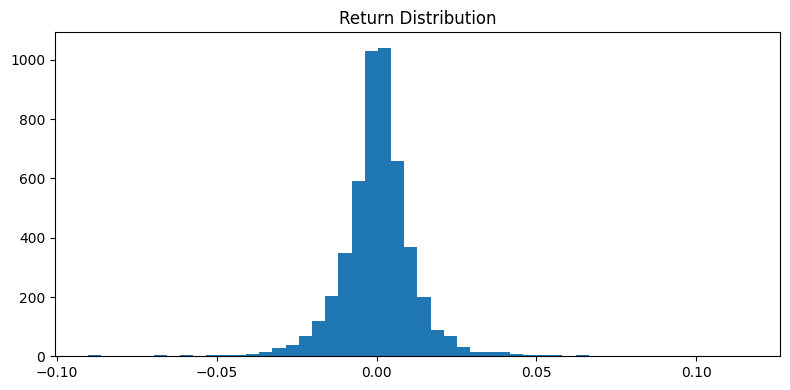

In [110]:
plt.figure(figsize=(8,4))
plt.hist(df['Return'].dropna(), bins=50)
plt.title("Return Distribution")
plt.tight_layout()
plt.show()

In [111]:
print("Return Summary Statistics")
print("-------------------------")
print("Mean:", round(df['Return'].mean(), 6))
print("Std Dev:", round(df['Return'].std(), 4))
print("Max:", round(df['Return'].max(), 4))
print("Min:", round(df['Return'].min(), 4))
print("Skewness:", round(df['Return'].skew(), 4))
print("Kurtosis:", round(df['Return'].kurt(), 4))

Return Summary Statistics
-------------------------
Mean: 0.000286
Std Dev: 0.0117
Max: 0.1159
Min: -0.0904
Skewness: 0.0038
Kurtosis: 9.4212


## 7. Moving Averages

Moving averages smooth short-term fluctuations.

- MA_20 → short-term trend
- MA_50 → medium-term trend

Crossovers may indicate regime shifts.

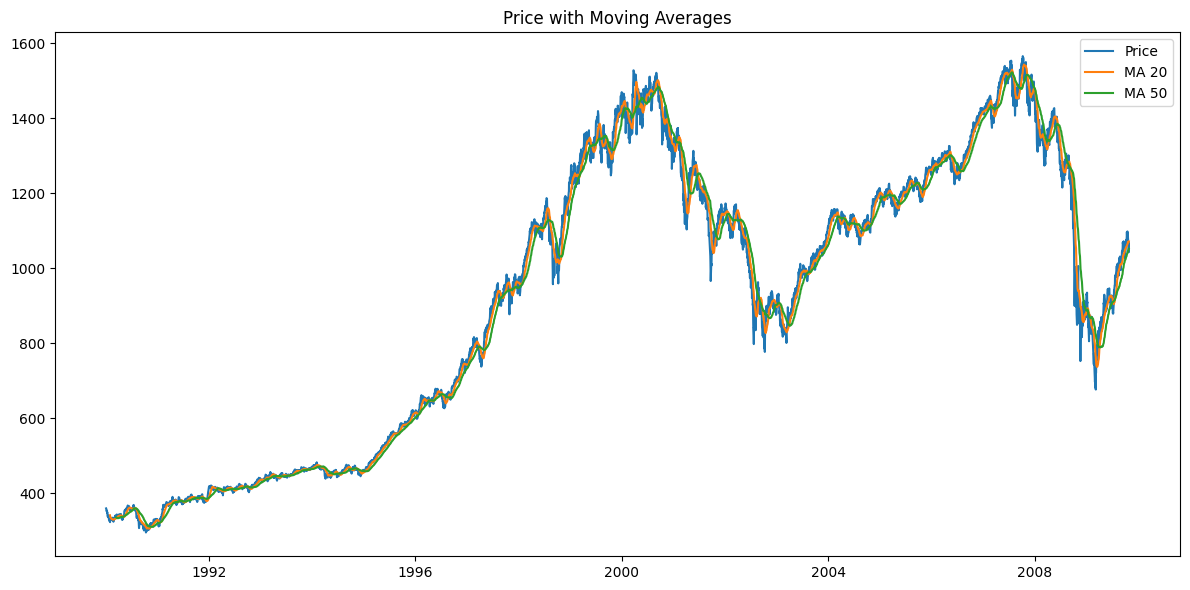

In [112]:
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Price'], label='Price')
plt.plot(df['Date'], df['MA_20'], label='MA 20')
plt.plot(df['Date'], df['MA_50'], label='MA 50')
plt.legend()
plt.title("Price with Moving Averages")
plt.tight_layout()
plt.show()

## 8. Rolling Volatility

Volatility measures dispersion of returns and approximates short-term risk.

The 20-day rolling standard deviation captures local market uncertainty.

Spikes typically align with:

- Market stress
- Economic shocks
- Financial crises

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(df['Date'], df['Volatility_20'])
plt.title("20-Day Rolling Volatility")
plt.tight_layout()
plt.show()

## 9. Cumulative Return

Cumulative return simulates the growth of $1 invested.

Computed as:

(1 + Return).cumprod()

This reflects long-term index performance.

In [ ]:
df['Cumulative_Return'] = (1 + df['Return']).cumprod()

plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Cumulative_Return'])
plt.title("Cumulative Growth of $1 Invested")
plt.tight_layout()
plt.show()

## 10. Maximum Drawdown

Maximum Drawdown (MDD) measures the largest peak-to-trough decline 
in cumulative returns.

It represents the worst historical loss an investor would have experienced.

Formula:

Drawdown_t = (Cumulative_t - Rolling_Max_t) / Rolling_Max_t

Maximum Drawdown = minimum(drawdown)

This is a key downside risk metric.

In [ ]:
df['Rolling_Max'] = df['Cumulative_Return'].cummax()

df['Drawdown'] = (
    df['Cumulative_Return'] - df['Rolling_Max']
) / df['Rolling_Max']

max_drawdown = df['Drawdown'].min()

print("Maximum Drawdown:", round(max_drawdown, 4))

plt.figure(figsize=(12,4))
plt.plot(df['Date'], df['Drawdown'])
plt.title("Drawdown Over Time")
plt.tight_layout()
plt.show()

## 11. Annualized Volatility

Annualized volatility scales daily standard deviation to yearly terms.

Assuming 252 trading days:

Annualized Volatility = daily_std × sqrt(252)

This reflects annualized market risk.

In [ ]:
import numpy as np

daily_vol = df['Return'].std()
annual_vol = daily_vol * np.sqrt(252)

print("Annualized Volatility:", round(annual_vol, 4))

## 12. Sharpe Ratio

The Sharpe Ratio measures risk-adjusted return.

Sharpe = (Mean Return - Risk-Free Rate) / Volatility

For simplicity, we assume risk-free rate = 0.

Annualized Sharpe:
(mean_daily × 252) / (daily_std × sqrt(252))

In [ ]:
mean_daily = df['Return'].mean()

annual_return = mean_daily * 252
annual_vol = df['Return'].std() * np.sqrt(252)

sharpe_ratio = annual_return / annual_vol

print("Annualized Sharpe Ratio:", round(sharpe_ratio, 4))

## 13. Rolling Sharpe Ratio

Rolling Sharpe measures time-varying risk-adjusted performance.

We compute a 252-day rolling Sharpe ratio 
(approximate 1 trading year).

In [ ]:
rolling_mean = df['Return'].rolling(252).mean()
rolling_std = df['Return'].rolling(252).std()

df['Rolling_Sharpe'] = (
    rolling_mean * 252
) / (rolling_std * np.sqrt(252))

plt.figure(figsize=(12,4))
plt.plot(df['Date'], df['Rolling_Sharpe'])
plt.title("Rolling 1-Year Sharpe Ratio")
plt.tight_layout()
plt.show()

## 14. Correlation Matrix

We examine relationships between engineered features:

- Return
- MA_20
- MA_50
- Volatility_20

This helps detect redundancy and structure.

In [113]:
corr = df[['Return', 'MA_20', 'MA_50', 'Volatility_20']].corr()

corr

,Return,MA_20,MA_50,Volatility_20
Return,1.000000,-0.024721,-0.024355,0.003103
MA_20,-0.024721,1.000000,0.997741,0.206893
MA_50,-0.024355,0.997741,1.000000,0.245194
Volatility_20,0.003103,0.206893,0.245194,1.000000


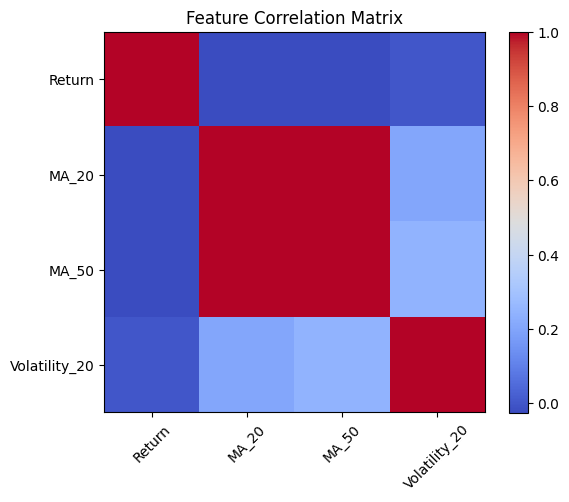

In [114]:
plt.figure(figsize=(6,5))
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

## 15. Statistical Testing

To formally validate the statistical properties of the dataset, we conduct:

1. **Augmented Dickey-Fuller (ADF) Test** for stationarity  
2. **Jarque-Bera (JB) Test** for normality  

These tests provide formal statistical evidence supporting the visual and descriptive analysis.

ADF Test Results
----------------
Price p-value: 0.5049962210832497
Return p-value: 4.963027063929431e-29

Jarque-Bera Test
----------------
JB p-value: 0.0


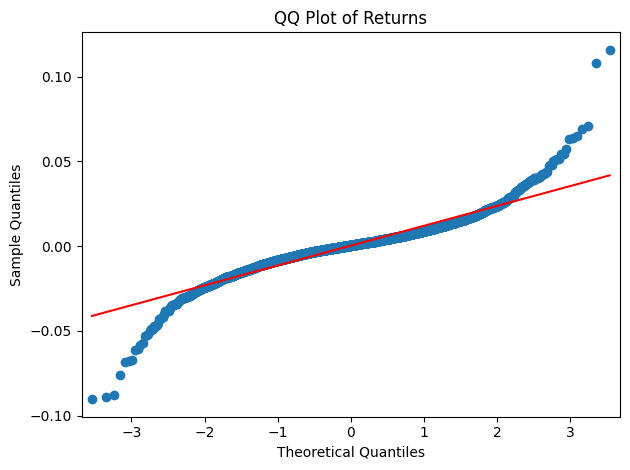

In [115]:
from statsmodels.tsa.stattools import adfuller
from scipy.stats import jarque_bera
import statsmodels.api as sm
import matplotlib.pyplot as plt


adf_price = adfuller(df['Price'].dropna())
adf_return = adfuller(df['Return'].dropna())

print("ADF Test Results")
print("----------------")
print("Price p-value:", adf_price[1])
print("Return p-value:", adf_return[1])


jb_stat, jb_pvalue = jarque_bera(df['Return'].dropna())

print("\nJarque-Bera Test")
print("----------------")
print("JB p-value:", jb_pvalue)


sm.qqplot(df['Return'].dropna(), line='s')
plt.title("QQ Plot of Returns")
plt.tight_layout()
plt.show()

### Statistical Test Results Interpretation

#### Augmented Dickey-Fuller (ADF) Test

Price p-value: 0.5050  
Return p-value: 4.96e-29  

At the 5% significance level:

- The p-value for **Price** is greater than 0.05.  
  We fail to reject the null hypothesis of a unit root.  
  → The price series is **non-stationary**.

- The p-value for **Return** is far below 0.05.  
  We reject the null hypothesis of a unit root.  
  → The return series is **stationary**.

This confirms a fundamental property of financial markets:
- Asset prices follow a non-stationary process.
- Returns are stationary and suitable for statistical modeling.



#### Jarque-Bera Test for Normality

JB p-value: 0.0  

The p-value is effectively zero (p < 0.05), therefore:

We reject the null hypothesis of normality.

This indicates that S&P 500 returns:

- Are not normally distributed  
- Exhibit fat tails (excess kurtosis)  
- Contain extreme observations more frequently than predicted by a normal distribution  

This result is consistent with well-documented empirical findings in financial econometrics.

## Final Conclusion

This notebook performed a comprehensive validation and statistical analysis of the processed S&P 500 dataset.

The dataset was confirmed to be:

- Chronologically ordered  
- Free of duplicate observations  
- Correctly feature-engineered  
- Consistent with expected rolling-window behavior  

Rolling NaN values were mathematically justified and confirm proper implementation of moving averages and volatility calculations.

Statistical testing confirms well-established stylized facts of financial time series:

- Price levels are non-stationary.
- Returns are stationary and centered near zero.
- Returns exhibit excess kurtosis (fat tails) and reject normality under the Jarque-Bera test.
- Volatility varies over time, as observed in rolling volatility and rolling Sharpe ratios.

Risk metrics such as maximum drawdown, annualized volatility, and the Sharpe ratio provide quantitative measures of market risk and performance. The time-varying Sharpe ratio further demonstrates that risk-adjusted performance changes across market regimes.

Overall, the empirical results align with financial theory and confirm that the dataset is statistically coherent, financially realistic, and suitable for advanced quantitative modeling, econometric analysis, or predictive applications.